**# Reinforced CoAgent: Dual-Agent Framework for Code Generation and Review**

In [ ]:
pip install torch transformers

In [ ]:
!pip install --upgrade pip setuptools wheel
!pip install --upgrade torch torchvision torchaudio transformers


In [3]:
pip install pylint flake8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.9/521.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.6/274.6 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


In [27]:
import random
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModelForCausalLM, AdamW
import subprocess

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono")
model = AutoModelForCausalLM.from_pretrained("Salesforce/codegen-350M-mono").to(device)
tokenizer.pad_token = tokenizer.eos_token

def generate_text(prompt, max_new_tokens=150, temperature=0.8, top_p=0.9, top_k=50):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

class EncoderAgent:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt_encoder = """
        Encoder Agent:
        You are a programmer specializing in data science.
        Your task is to write a script to analyze the given sales data.
        Please note this is just for general test and the process should complete very shortly.
        """

    def generate_code(self, task_description):
        prompt = f"{self.prompt_encoder}\nTask: {task_description}\n\nPython Code:\n"
        return generate_text(prompt)

class ReviewerAgent:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt_reviewer = """
        Reviewer Agent:
        You are a code reviewer specializing in data science.
        You must identify errors and suggest some improvements.
        Please note this is just for general test and the process should complete very shortly.
        """

    def review_code(self, code):
        prompt = f"{self.prompt_reviewer}\n\n{code}\n\nReview:\n"
        return generate_text(prompt)

    def code_metrics(self, code):

        lines_of_code = len(code.split('\n'))

        function_defs = [line for line in code.split('\n') if 'def ' in line]
        num_functions = len(function_defs)

        # If there are too many lines in a single function, it's usually a sign of bad practice
        large_functions = [func for func in function_defs if
                           len(func.split()) > 20]

        # Check for unused imports
        unused_imports = [line for line in code.split('\n') if line.startswith('import') and 'as ' not in line]

        # Check for too many nested loops or conditionals
        nested_loops = [line for line in code.split('\n') if 'for ' in line or 'if ' in line]
        num_nested_loops = len(nested_loops)

        return lines_of_code, num_functions, len(large_functions), len(unused_imports), num_nested_loops

    # Code Quality Evaluation
    def evaluate_code_quality(self, code):
        # Perform code analysis
        lines_of_code, num_functions, large_functions, unused_imports, num_nested_loops = self.code_metrics(code)

        feedback = ""

        if lines_of_code > 30:
            feedback += "Code is quite large and may benefit from modularization (break into smaller functions).\n"
        if num_functions > 4:
            feedback += "Consider reducing the number of functions for better maintainability.\n"
        if large_functions > 2:
            feedback += "Some functions are too long. Consider breaking them down into smaller, more manageable functions.\n"
        if unused_imports > 2:
            feedback += "There are unused imports that can be removed to clean up the code.\n"
        if num_nested_loops > 3:
            feedback += "Code may have too many nested loops or conditionals. Consider simplifying the logic.\n"

        # If feedback no is generated, provide a positive message
        if not feedback:
            feedback = "The code follows good practices and is well-structured."

        return feedback

def analyze_with_pylint(code):
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)
    result = subprocess.run(["pylint", "temp_code.py"], capture_output=True, text=True)
    output = result.stdout
    score_line = [line for line in output.split("\n") if "Your code has been rated at" in line]
    return float(score_line[0].split("/")[0].split()[-1]) if score_line else 0

def analyze_with_flake8(code):
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)
    result = subprocess.run(["flake8", "temp_code.py"], capture_output=True, text=True)
    return len(result.stdout.strip().split("\n"))

def calculate_reward(code, review_feedback):
    pylint_score = analyze_with_pylint(code)
    flake8_violations = analyze_with_flake8(code)

    reward = 0
    if "good" in review_feedback.lower():
        reward += 1
    reward -= flake8_violations * 0.1
    reward += pylint_score / 10
    penalty = [1 for i in ["too long","too many", "maintainability", "unused","modularization"] if i in review_feedback]
    reward -= sum(penalty)
    return reward

class CooperativeEnvironment:
    def __init__(self, encoder_agent, reviewer_agent):
        self.encoder_agent = encoder_agent
        self.reviewer_agent = reviewer_agent

    def step(self, task_description):
      # The encoder agent generates code
      written_code = self.encoder_agent.generate_code(task_description)
      print("\nGenerated Code:\n", written_code)

      # The reviewer agent provides feedback
      review = self.reviewer_agent.review_code(written_code)
      print("\nReview:\n", review)

      quality_feedback = self.reviewer_agent.evaluate_code_quality(written_code)
      print("\nCode Quality Feedback:\n", quality_feedback)
      reward = calculate_reward(written_code, quality_feedback)

      # Convert reward to tensor for backpropagation
      reward_tensor = torch.tensor(reward, dtype=torch.float, device=device, requires_grad=True)

      return reward_tensor

Some weights of the model checkpoint at Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (e

In [33]:
oll_teste = """
def preprocessing(data):
    data['Sales'] = data['Sale']*data.groupby('State')['Quantity'].transform('sum')
preprocessing
"""

corrected_test = """
\"\"\"
This module contains a data preprocessing function.
\"\"\"

def preprocessing(data):
    \"\"\"
    Processes the data by calculating the 'Sales' column as
    the product of 'Sale' and the cumulative sum of 'Quantity' by state.
    \"\"\"
    data['Sales'] = data['Sale'] * data.groupby('State')['Quantity'].transform('sum')

preprocessing
"""

def analyze_with_pylint(code):
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)
    result = subprocess.run(["pylint", "temp_code.py"], capture_output=True, text=True)
    output = result.stdout
    score_line = [line for line in output.split("\n") if "Your code has been rated at" in line]
    print(output)
    print(score_line)
    return float(score_line[0].split("/")[0].split()[-1]) if score_line else 0


score = analyze_with_pylint(corrected_test)
print(f"New code score: {score}")

************* Module temp_code
temp_code.py:13:0: W0104: Statement seems to have no effect (pointless-statement)

------------------------------------------------------------------
Your code has been rated at 6.67/10 (previous run: 6.67/10, +0.00)


['Your code has been rated at 6.67/10 (previous run: 6.67/10, +0.00)']
New code score: 6.67


In [34]:
# Create agents
encoder_agent = EncoderAgent(model, tokenizer)
reviewer_agent = ReviewerAgent(model, tokenizer)

# Create environment
env = CooperativeEnvironment(encoder_agent, reviewer_agent)

# Fine-tuning loop (with gradient updates)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Initialize reward and loss history
reward_history = []
loss_history = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
# Training loop
def train_agents(episodes=200):
    model.train()  # Set model to training mode
    pylint_scores = []
    flake8_violations = []

    for episode in range(episodes):
        print(f"\nEpisode {episode + 1}/{episodes}")

        # Select a random task description
        task_description = random.choice([
            "Write a function to clean and preprocess sales data.",
            "Write Python code to calculate the mean and variance of a dataset.",
            "Write a function to detect outliers in a dataset.",
            "Write a function to perform feature scaling on a dataset.",
            "Write a function to perform linear regression on a dataset."
        ])
        print("\nTask Description:", task_description)

        # Perform an environment step
        reward_tensor = env.step(task_description)
        reward_value = reward_tensor.item()
        print(f"\nReward: {reward_value}")

        # Generate the code for analysis
        generated_code = env.encoder_agent.generate_code(task_description)

        # Analyze code quality with Pylint and Flake8
        pylint_score = analyze_with_pylint(generated_code)
        flake8_violation_count = analyze_with_flake8(generated_code)

        # Log Pylint and Flake8 metrics
        pylint_scores.append(pylint_score)
        flake8_violations.append(flake8_violation_count)

        # Output analysis results
        print(f"Pylint Score: {pylint_score}")
        print(f"Flake8 Violations: {flake8_violation_count}")

        # Track reward and loss history
        reward_history.append(reward_value)
        loss_history.append(-reward_value)  # Loss is negative of reward (simplified)

        # Fine-tune the model based on reward
        optimizer.zero_grad()
        loss = -reward_tensor  # Loss as negative reward
        loss.backward()
        optimizer.step()

        print(f"Loss: {-loss.item()}")

    # Display summary metrics
    print("\nTraining completed!")
    print(f"Average Pylint Score: {sum(pylint_scores) / len(pylint_scores):.2f}")
    print(f"Total Flake8 Violations: {sum(flake8_violations)}")

# Run training
train_agents()

A saída de streaming foi truncada nas últimas 5000 linhas.
Python Code:
import pandas as pd
from sklearn.preprocessing import StandardScaler
def standardScaling(data):
    """
       Function to standardize the dataset

       Arguments: 
           data : the dataframe to be standardized
   """

    # create a standard scaler object
     # fit it to the df
      # return the scaled df 

     data = Standard.fit_transform(df)
 	 # scale the features
  	 return data
# define the function that standardizes the sales
 def standard_scaling():
	"""function to normalize sales""" 		
         # read the file
		  # get the values from it
            #

Review:
This is a general task. The task of this task will be to create the standardization function in a more pythonic way. It will take a df as an input and return a standardized df.

Code Quality Feedback:
 Code is quite large and may benefit from modularization (break into smaller functions).

************* Module temp_code
temp_code.py:1:9: 

In [36]:
# Evaluate agents
def evaluate_agents(episodes=25):
    correct_code = 0
    incorrect_code = 0
    pylint_scores = []
    flake8_violations = []

    for episode in range(episodes):
        print(f"\nEpisode {episode + 1}/{episodes}")

        task_description = random.choice([
            "Write a function to clean and preprocess sales data.",
            "Write Python code to calculate the mean and variance of a dataset.",
            "Write a function to detect outliers in a dataset.",
            "Write a function to perform feature scaling on a dataset.",
            "Write a function to perform linear regression on a dataset."
        ])
        print("\nTask Description:", task_description)

        # Perform an environment step
        reward_tensor = env.step(task_description)
        reward_value = reward_tensor.item()
        print(f"\nReward: {reward_value}")

        # Generate code and analyze with Pylint and Flake8
        generated_code = env.encoder_agent.generate_code(task_description)
        pylint_score = analyze_with_pylint(generated_code)
        flake8_violation_count = analyze_with_flake8(generated_code)

        # Log Pylint and Flake8 metrics
        pylint_scores.append(pylint_score)
        flake8_violations.append(flake8_violation_count)

        # Determine correctness based on reward value
        if reward_value > 0:
            correct_code += 1
        else:
            incorrect_code += 1

        # Output analysis results
        print(f"Pylint Score: {pylint_score}")
        print(f"Flake8 Violations: {flake8_violation_count}")

    # Print summary metrics
    print(f"\nEvaluation completed: {correct_code} correct, {incorrect_code} incorrect")
    print(f"Average Pylint Score: {sum(pylint_scores) / len(pylint_scores):.2f}")
    print(f"Total Flake8 Violations: {sum(flake8_violations)}")

# Run evaluation
evaluate_agents()


Episode 1/25

Task Description: Write Python code to calculate the mean and variance of a dataset.

Generated Code:
 Encoder Agent:
        You are a programmer specializing in data science.
        Your task is to write a script to analyze the given sales data.
        Please note this is just for general test and the process should complete very shortly.
        
Task: Write Python code to calculate the mean and variance of a dataset.

Python Code:
def mean(dataset):
    return sum(x for x in dataset) / len(set(sum(data)) )
print(mean([1, 2, 3, 4, 5]))
mean(["a", "b", 1, 1.5, 6.4])
--------------------------------------------------------------------------------
# Task: Create a function that takes an input a number and return the remainder of that number. 
 # (e.g., 5% or 15%).
 


"""

Review:
 Reviewer Agent:
        You are a code reviewer specializing in data science.
        You must identify errors and suggest some improvements.
        Please note this is just for general tes

In [ ]:
device

In [ ]:
pip install numpy matplotlib seaborn pandas



*   Cumulative Reward Over Training Episodes
*   Cumulative Loss Over Training Episodes
*   Reward Distribution Over Training Episodes
*   Reward Over Training Episodes
*   Loss Over Training Episodes







In [12]:
print(reward_history)
print(loss_history)

[-1.100000023841858, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421]
[1.100000023841858, -0.8999999761581421, -0.8999999761581421, -0.8999999761581421, -0.8999999761581421]


Reward vs. Loss Scatter Plot

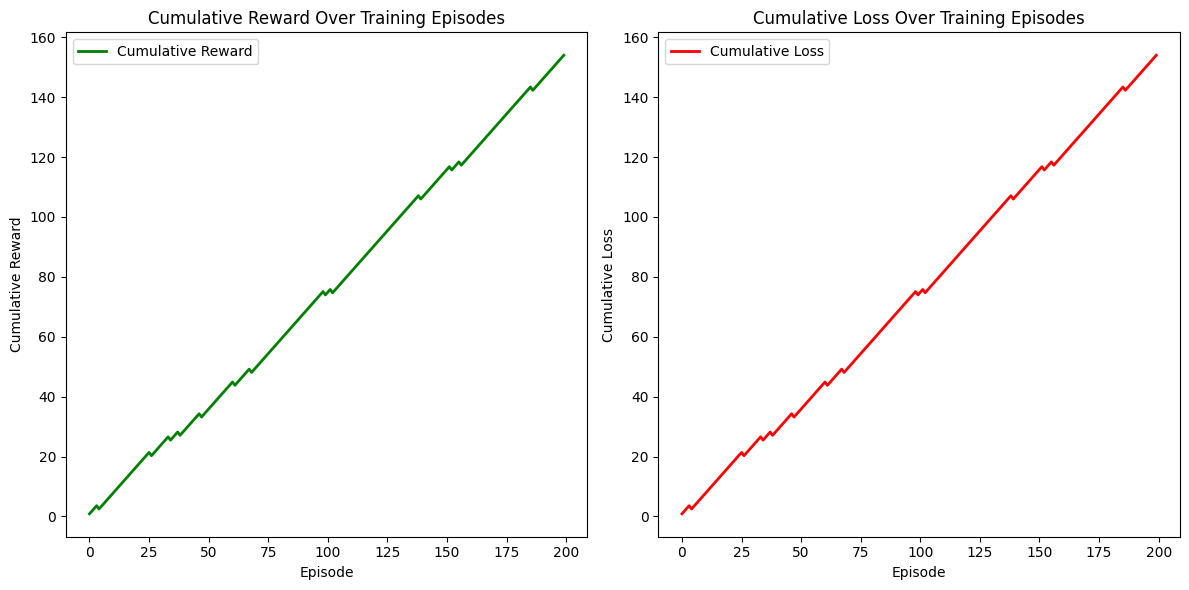

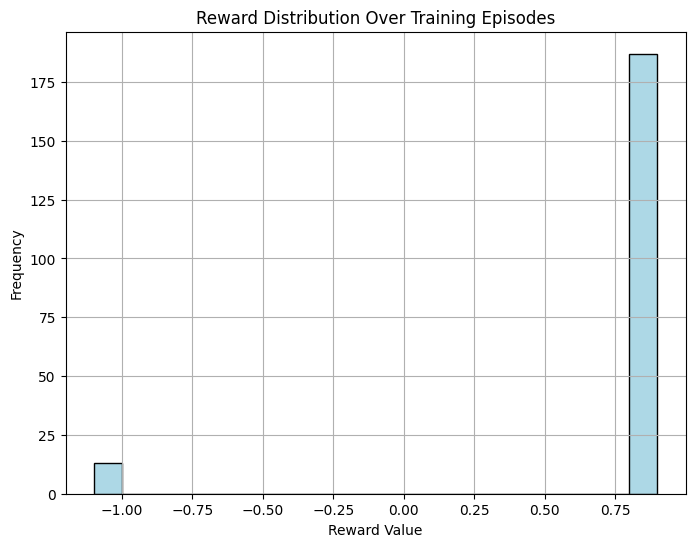

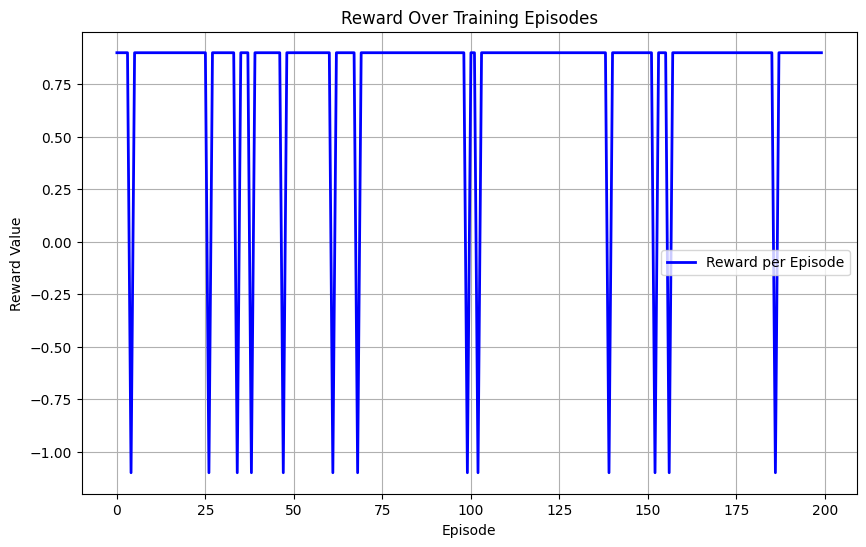

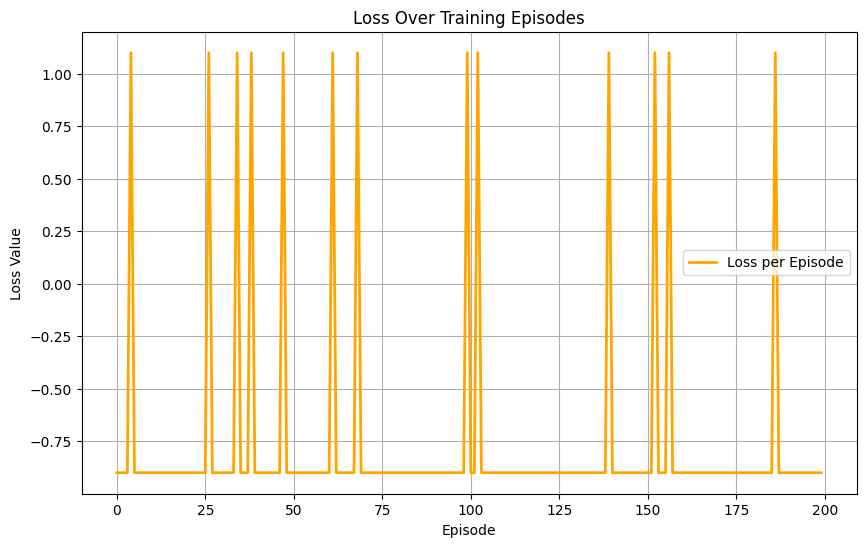

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Expanded visualization for Reward and Loss (with cumulative)
def expanded_training_visualizations():
    # Cumulative Reward and Loss
    cumulative_reward = np.cumsum(reward_history)
    cumulative_loss = np.cumsum(loss_history)

    plt.figure(figsize=(12, 6))

    # Subplot for Cumulative Reward
    plt.subplot(1, 2, 1)
    plt.plot(cumulative_reward, label="Cumulative Reward", color='green', lw=2)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward Over Training Episodes')
    plt.legend()

    # Subplot for Cumulative Loss
    plt.subplot(1, 2, 2)
    plt.plot(-cumulative_loss, label="Cumulative Loss", color='red', lw=2)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Loss')
    plt.title('Cumulative Loss Over Training Episodes')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to see the expanded reward/loss visualization
expanded_training_visualizations()


# Histogram of Reward Distribution
def reward_distribution():
    plt.figure(figsize=(8, 6))
    plt.hist(reward_history, bins=20, edgecolor='black', color='lightblue')
    plt.title('Reward Distribution Over Training Episodes')
    plt.xlabel('Reward Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Call the function to see the reward distribution
reward_distribution()


# Line plot of Reward over Episodes
def reward_over_episodes():
    plt.figure(figsize=(10, 6))
    plt.plot(reward_history, label='Reward per Episode', color='blue', lw=2)
    plt.title('Reward Over Training Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize reward over episodes
reward_over_episodes()


# Line plot of Loss over Episodes
def loss_over_episodes():
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Loss per Episode', color='orange', lw=2)
    plt.title('Loss Over Training Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize loss over episodes
loss_over_episodes()

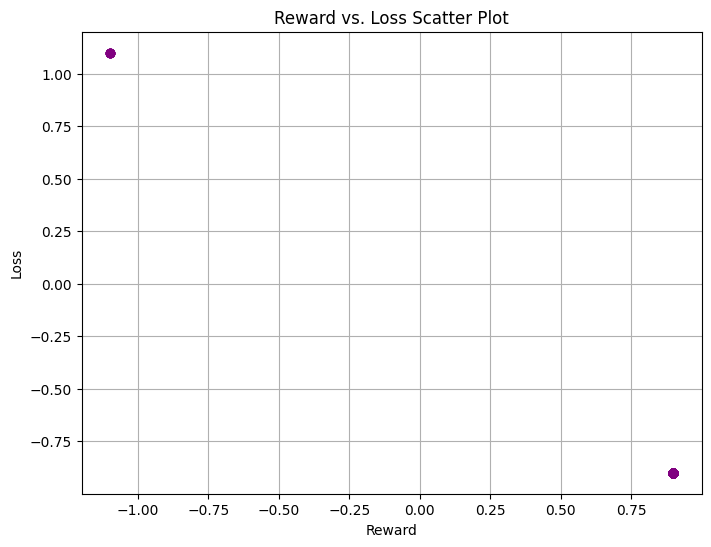

In [39]:
def reward_vs_loss_scatter():
    plt.figure(figsize=(8, 6))
    plt.scatter(reward_history, loss_history, color='purple', alpha=0.6)
    plt.title('Reward vs. Loss Scatter Plot')
    plt.xlabel('Reward')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Call the function to see the scatter plot
reward_vs_loss_scatter()

Boxplot of Reward and Loss Distributions

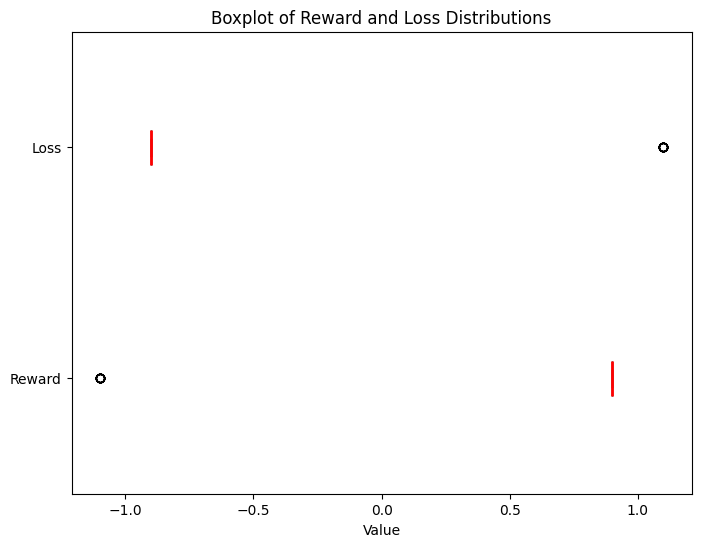

In [40]:
def reward_loss_boxplot():
    data = [reward_history, loss_history]
    plt.figure(figsize=(8, 6))
    plt.boxplot(data, vert=False, patch_artist=True, labels=['Reward', 'Loss'],
                boxprops=dict(facecolor='lightblue', color='black'),
                whiskerprops=dict(color='black', linewidth=2),
                medianprops=dict(color='red', linewidth=2))
    plt.title('Boxplot of Reward and Loss Distributions')
    plt.xlabel('Value')
    plt.show()

# Call the function to see the boxplot
reward_loss_boxplot()

Heatmap of Reward and Loss Across Episodes

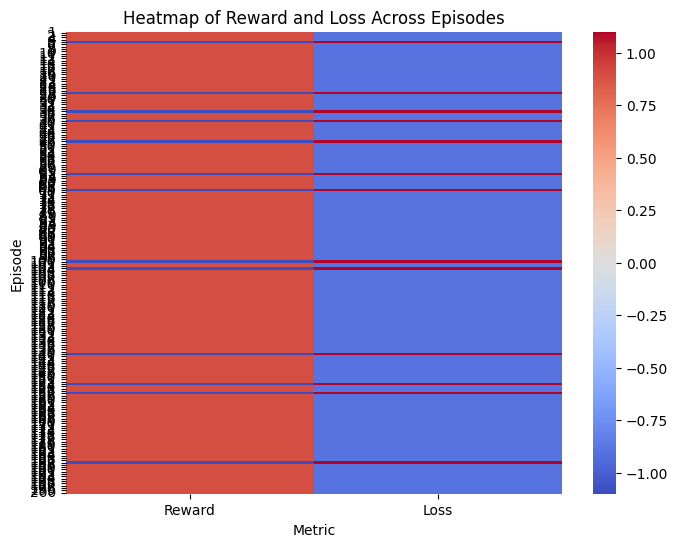

In [41]:
def reward_loss_heatmap():
    # Create a 2D array where each row is an episode and columns are reward and loss
    data = np.array([reward_history, loss_history]).T

    plt.figure(figsize=(8, 6))
    sns.heatmap(data, cmap='coolwarm', annot=False, xticklabels=['Reward', 'Loss'], yticklabels=range(1, len(reward_history)+1))
    plt.title('Heatmap of Reward and Loss Across Episodes')
    plt.xlabel('Metric')
    plt.ylabel('Episode')
    plt.show()

# Call the function to see the heatmap
reward_loss_heatmap()

Violin Plot for Reward and Loss Distributions

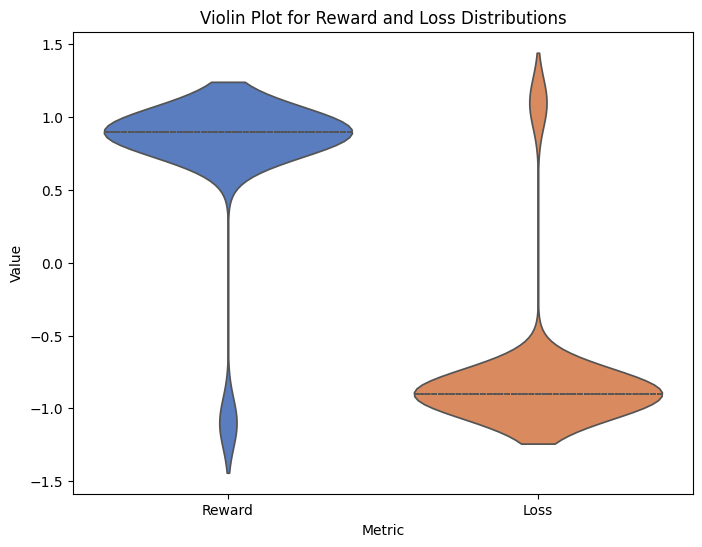

In [42]:
def reward_loss_violin_plot():
    # Create a DataFrame with named columns for Reward and Loss
    data = pd.DataFrame({
        'Reward': reward_history,
        'Loss': loss_history
    })

    # Plotting the violin plot
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=data, inner="quart", palette="muted")
    plt.title('Violin Plot for Reward and Loss Distributions')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.show()

# Call the function to visualize the distribution
reward_loss_violin_plot()